# Classification of blood-brain-barrier permeability data using molecular descriptors

**Input data**: Simplified Molecular Input Line Entry System (SMILES) strings as molecular descriptors converted to feature embeddings with RDKit Molecular Descriptors.

In [1]:
from os.path import join

import numpy as np
import pandas as pd

import deepchem as dc
from rdkit import Chem

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer

from molecule_gym.config import DATA_DIR, RESULTS_DIR
from molecule_gym.core.classifiers import classify_binary_data
from molecule_gym.core.visualizations import plot_explained_variance

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

2023-06-22 09:39:47.238453: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-22 09:39:47.240413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:39:47.270216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:39:47.270737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 09:39:47.781033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Importing the raw dataset

Loading the raw dataset into a dataframe.

In [2]:
df_raw = pd.read_csv(join(DATA_DIR, 'physiology', 'BBBP.csv'))

In [3]:
df_raw.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [4]:
df_raw.shape

(2050, 4)

### Drop molecules that cannot be featurized

In [5]:
mols = [Chem.MolFromSmiles(smile) for smile in df_raw['smiles']]

[09:39:50] Explicit valence for atom # 1 N, 4, is greater than permitted
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] Explicit valence for atom # 11 N, 4, is greater than pe

In [6]:
use_mol = []
for mol in mols:
    if mol is not None:
        use_mol.append(True)
    else:
        use_mol.append(False)

In [7]:
df_raw['use_mol'] = use_mol

In [8]:
df_raw.head(63)

,num,name,p_np,smiles,use_mol
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,True
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,True
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,True
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,True
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,True
...,...,...,...,...,...
58,59,Y-G 14,1,n(ccc1)c(c1)CCNC,True
59,60,15,1,O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3,False
60,61,sertraline,1,[Cl-].CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c3cccc...,True
61,62,22767,1,c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC,False


In [9]:
df_raw.shape

(2050, 5)

In [10]:
df = df_raw.loc[df_raw['use_mol']== True].copy(deep=True)

In [11]:
df.shape

(2039, 5)

In [12]:
labels = df['p_np']
labels.value_counts()

1    1560
0     479
Name: p_np, dtype: int64

## Generate numeric feature embeddings of SMILES strings with RDKit

In [13]:
mols = [Chem.MolFromSmiles(smile) for smile in df['smiles']]

[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors


[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not removing hydrogen atom without neighbors
[09:39:50] WARNING: not r

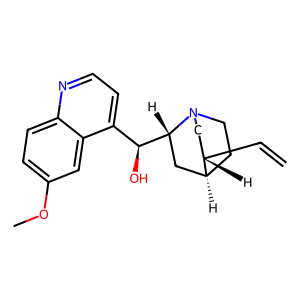

In [14]:
Chem.Draw.MolToImage(mols[50])

In [15]:
featurizer = dc.feat.RDKitDescriptors()

In [16]:
features = featurizer.featurize(mols)

[09:39:51] WARNING: not removing hydrogen atom without neighbors
[09:39:51] WARNING: not removing hydrogen atom without neighbors
[09:39:51] WARNING: not removing hydrogen atom without neighbors
[09:39:51] WARNING: not removing hydrogen atom without neighbors
[09:39:52] WARNING: not removing hydrogen atom without neighbors
[09:39:52] WARNING: not removing hydrogen atom without neighbors
[09:39:52] WARNING: not removing hydrogen atom without neighbors
[09:39:52] WARNING: not removing hydrogen atom without neighbors
[09:39:53] WARNING: not removing hydrogen atom without neighbors
[09:39:53] WARNING: not removing hydrogen atom without neighbors
[09:39:53] WARNING: not removing hydrogen atom without neighbors
[09:39:53] WARNING: not removing hydrogen atom without neighbors
[09:39:53] WARNING: not removing hydrogen atom without neighbors
[09:39:53] WARNING: not removing hydrogen atom without neighbors
[09:39:54] WARNING: not removing hydrogen atom without neighbors
[09:39:54] WARNING: not r

In [17]:
# Distribution description of a feature sample
features_describe = pd.DataFrame(features[80,:])
features_describe.describe()

,0
count,209.000000
mean,8.975955
std,35.943929
min,-2.189281
25%,0.000000
50%,0.000000
75%,5.000000
max,338.921052


In [18]:
normalizer = QuantileTransformer(output_distribution='uniform')

In [19]:
features_norm = normalizer.fit_transform(features)

In [20]:
features_norm_describe = pd.DataFrame(features_norm[80,:])
features_norm_describe.describe()

,0
count,209.000000
mean,0.244215
std,0.323129
min,0.000000
25%,0.000000
50%,0.091117
75%,0.416880
max,1.000000


## Binary classification with embeddings data

In [21]:
features_norm.shape

(2039, 209)

In [22]:
features_norm[np.isnan(features_norm)] = 0

In [23]:
labels.value_counts()

1    1560
0     479
Name: p_np, dtype: int64

In [24]:
labels[:966].value_counts()

1    487
0    479
Name: p_np, dtype: int64

Training target statistics: Counter({1: 342, 0: 334})
Testing target statistics: Counter({1: 145, 0: 145})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       334
           1       0.98      0.99      0.99       342

    accuracy                           0.99       676
   macro avg       0.99      0.99      0.99       676
weighted avg       0.99      0.99      0.99       676


Model performance on test data:
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       145
           1       0.79      0.86      0.82       145

    accuracy                           0.81       290
   macro avg       0.82      0.81      0.81       290
weighted avg       0.82      0.81      0.81       290



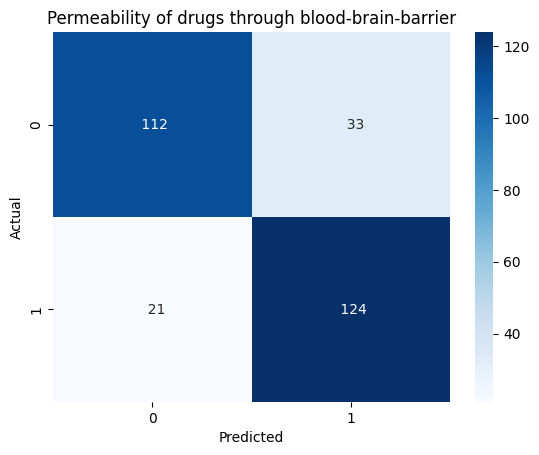

In [25]:
classify_binary_data(features_norm[:966, :], labels[:966])

## Feature reduction with PCA Analysis

In [26]:
pca = PCA()

In [27]:
features_transformed = pca.fit_transform(features_norm)

In [28]:
exp_var_pca = pca.explained_variance_ratio_[:40]
exp_var_pca

array([0.22770394, 0.09339879, 0.08403959, 0.047076  , 0.03723982,
       0.03654554, 0.03157558, 0.0284056 , 0.0239571 , 0.02162725,
       0.01950649, 0.01762397, 0.01560441, 0.01502287, 0.01290708,
       0.01213466, 0.01056034, 0.01030328, 0.0101104 , 0.00889784,
       0.00887255, 0.00852674, 0.00789299, 0.00748292, 0.00722138,
       0.00692589, 0.00671426, 0.00614902, 0.00590436, 0.00587338,
       0.00577872, 0.00548872, 0.00495402, 0.00488743, 0.00468584,
       0.00456924, 0.00426465, 0.00422682, 0.00399483, 0.00387362])

In [29]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

array([0.22770394, 0.32110272, 0.40514231, 0.45221831, 0.48945813,
       0.52600367, 0.55757925, 0.58598485, 0.60994195, 0.6315692 ,
       0.65107569, 0.66869966, 0.68430407, 0.69932695, 0.71223402,
       0.72436868, 0.73492902, 0.74523231, 0.75534271, 0.76424055,
       0.7731131 , 0.78163984, 0.78953284, 0.79701576, 0.80423714,
       0.81116303, 0.81787729, 0.82402631, 0.82993067, 0.83580405,
       0.84158278, 0.8470715 , 0.85202552, 0.85691295, 0.86159879,
       0.86616803, 0.87043269, 0.87465951, 0.87865434, 0.88252796])

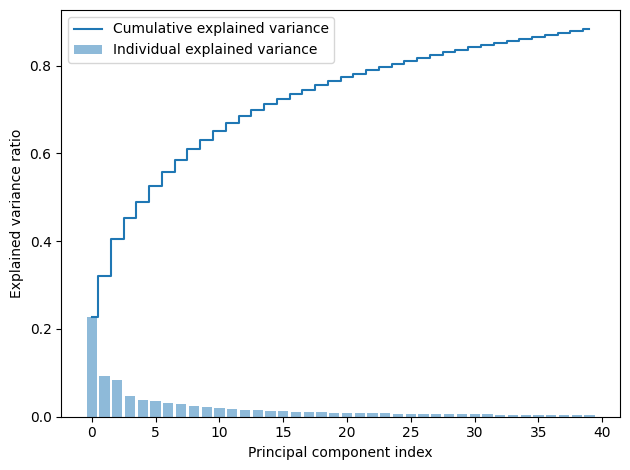

In [30]:
plot_explained_variance(exp_var_pca)

In [31]:
features_reduced = features_transformed[:,:40]

In [32]:
features_reduced.shape

(2039, 40)

Training target statistics: Counter({1: 342, 0: 334})
Testing target statistics: Counter({1: 145, 0: 145})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       334
           1       0.95      0.98      0.97       342

    accuracy                           0.96       676
   macro avg       0.96      0.96      0.96       676
weighted avg       0.96      0.96      0.96       676


Model performance on test data:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       145
           1       0.78      0.82      0.80       145

    accuracy                           0.80       290
   macro avg       0.80      0.80      0.80       290
weighted avg       0.80      0.80      0.80       290



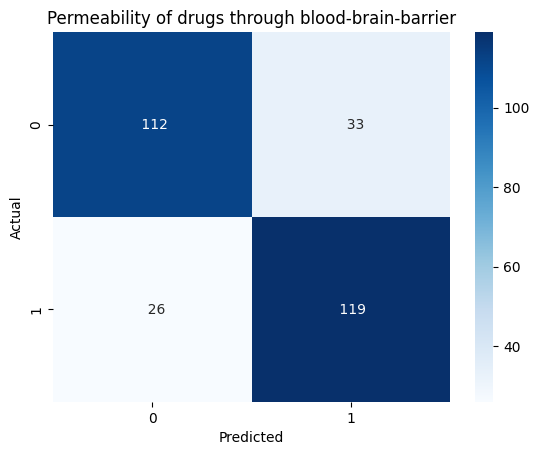

In [33]:
classify_binary_data(features_reduced[:966, :], labels[:966])

## Oversampling the smallest class

**Note**: Split the data first. Otherwise, there will be data sharing between the training and test data which will artificially increase the accuracy.

Training target statistics: Counter({1: 1077, 0: 1077})
Testing target statistics: Counter({1: 483, 0: 483})
Using SVC classifier



Model performance on training data:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1077
           1       0.97      0.98      0.97      1077

    accuracy                           0.97      2154
   macro avg       0.97      0.97      0.97      2154
weighted avg       0.97      0.97      0.97      2154


Model performance on test data:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       483
           1       0.83      0.94      0.88       483

    accuracy                           0.87       966
   macro avg       0.88      0.87      0.87       966
weighted avg       0.88      0.87      0.87       966



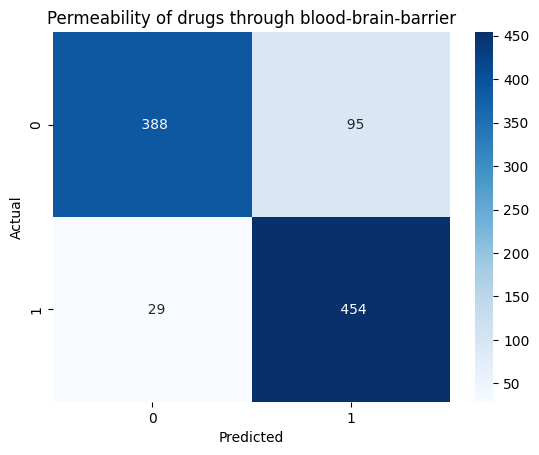

In [34]:
classify_binary_data(features_reduced, labels, sampling='oversample')

## Undersampling the largest class

Training target statistics: Counter({0: 349, 1: 349})
Testing target statistics: Counter({0: 130, 1: 130})
Using SVC classifier

Model performance on training data:


              precision    recall  f1-score   support

           0       0.98      0.95      0.97       349
           1       0.96      0.98      0.97       349

    accuracy                           0.97       698
   macro avg       0.97      0.97      0.97       698
weighted avg       0.97      0.97      0.97       698


Model performance on test data:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       130
           1       0.82      0.89      0.86       130

    accuracy                           0.85       260
   macro avg       0.85      0.85      0.85       260
weighted avg       0.85      0.85      0.85       260



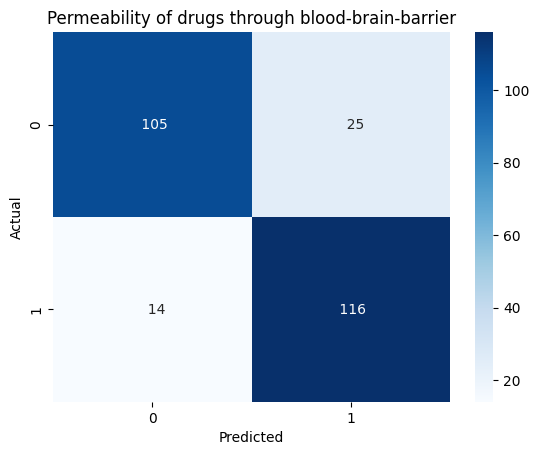

In [35]:
classify_binary_data(features_reduced, labels, sampling='undersample')

## Pycaret pipeline for classification

In [36]:
from pycaret.classification import *

In [37]:
reduced_data = pd.DataFrame(features_reduced)
reduced_data['labels'] = labels

In [38]:
features_reduced.shape

(2039, 40)

In [47]:
sum(reduced_data['labels'].isnull())

0

In [40]:
reduced_data.shape

(2039, 41)

In [46]:
reduced_data = reduced_data[reduced_data['labels'].notnull()]
reduced_data.shape

(2028, 41)

In [48]:
exp_clf101 = setup(data=reduced_data, target='labels',
                   #preprocess=True, imputation_type='iterative',
                   fold_strategy='kfold', fold_shuffle=True,
                   fix_imbalance=True, fix_imbalance_method='RandomUnderSampler',
                   normalize=False, normalize_method='robust',
                   remove_multicollinearity=False, multicollinearity_threshold=0.9,
                   experiment_name='bbbp_classifier_chemberta2',
                   memory=RESULTS_DIR, profile=True,
                   session_id=69763)

,Description,Value
0,Session id,69763
1,Target,labels
2,Target type,Binary
3,Original data shape,"(2028, 41)"
4,Transformed data shape,"(1279, 41)"
5,Transformed train set shape,"(670, 41)"
6,Transformed test set shape,"(609, 41)"
7,Numeric features,40
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [49]:
top_n = compare_models(sort='F1', n_select=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7858,0.7993,0.8188,0.8912,0.8531,0.4564,0.4632,0.2140
knn,K Neighbors Classifier,0.7823,0.8001,0.8203,0.8868,0.8516,0.4430,0.4500,0.1530
lr,Logistic Regression,0.7788,0.7905,0.8049,0.8960,0.8472,0.4490,0.4602,0.3920
lda,Linear Discriminant Analysis,0.7766,0.7862,0.8126,0.8857,0.8469,0.4328,0.4403,0.1050
nb,Naive Bayes,0.7682,0.7803,0.8029,0.8839,0.8409,0.4160,0.4248,0.1100
ridge,Ridge Classifier,0.7675,0.0000,0.8010,0.8842,0.8401,0.4157,0.4241,0.1090
rf,Random Forest Classifier,0.7688,0.8043,0.7964,0.8903,0.8398,0.4281,0.4395,0.2480
qda,Quadratic Discriminant Analysis,0.7611,0.7884,0.7908,0.8852,0.8346,0.4084,0.4198,0.1020
gbc,Gradient Boosting Classifier,0.7568,0.7869,0.7806,0.8880,0.8302,0.4079,0.4210,0.2380
lightgbm,Light Gradient Boosting Machine,0.7568,0.8022,0.7753,0.8916,0.8291,0.4116,0.4254,0.1640


### Fine tuning best model

In [50]:
best_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7606,0.8205,0.7870,0.8854,0.8333,0.4135,0.4227
1,0.7465,0.7794,0.7748,0.8866,0.8269,0.3612,0.3728
2,0.8099,0.8648,0.8241,0.9175,0.8683,0.5300,0.5400
3,0.7746,0.8412,0.8000,0.8980,0.8462,0.4303,0.4405
4,0.7535,0.8221,0.7876,0.8900,0.8357,0.3500,0.3607
5,0.7958,0.7967,0.8246,0.9126,0.8664,0.4382,0.4485
6,0.7324,0.7717,0.7714,0.8526,0.8100,0.3614,0.3666
7,0.7465,0.7851,0.8056,0.8529,0.8286,0.3436,0.3457
8,0.7113,0.7059,0.7864,0.8100,0.7980,0.2922,0.2926


In [51]:
tuned_model = tune_model(best_model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7606,0.7579,0.8519,0.8364,0.8440,0.3291,0.3293
1,0.8310,0.7716,0.9009,0.8850,0.8929,0.4930,0.4934
2,0.8099,0.7993,0.9074,0.8522,0.8789,0.4383,0.4430
3,0.8310,0.8091,0.8818,0.8981,0.8899,0.5264,0.5268
4,0.8169,0.8529,0.8584,0.9065,0.8818,0.4769,0.4804
5,0.8239,0.7682,0.8772,0.9009,0.8889,0.4655,0.4665
6,0.7817,0.7367,0.8857,0.8304,0.8571,0.3965,0.4002
7,0.7817,0.7059,0.8519,0.8598,0.8558,0.4066,0.4067
8,0.7817,0.7530,0.8932,0.8214,0.8558,0.4098,0.4159


Fitting 10 folds for each of 10 candidates, totalling 100 fits


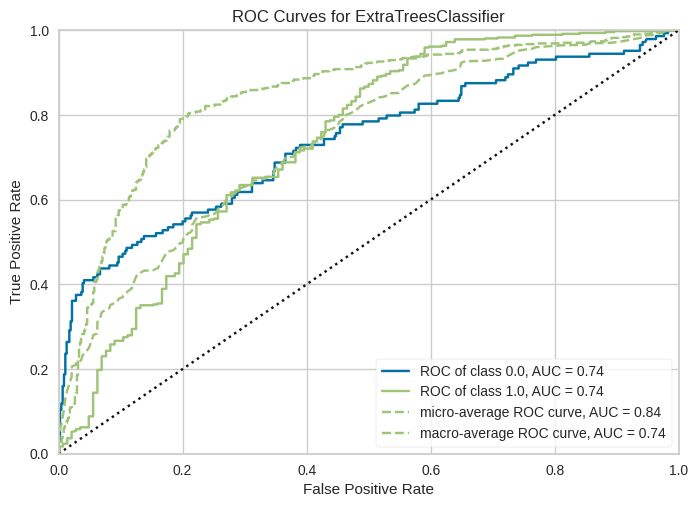

In [52]:
plot_model(tuned_model, plot = 'auc')

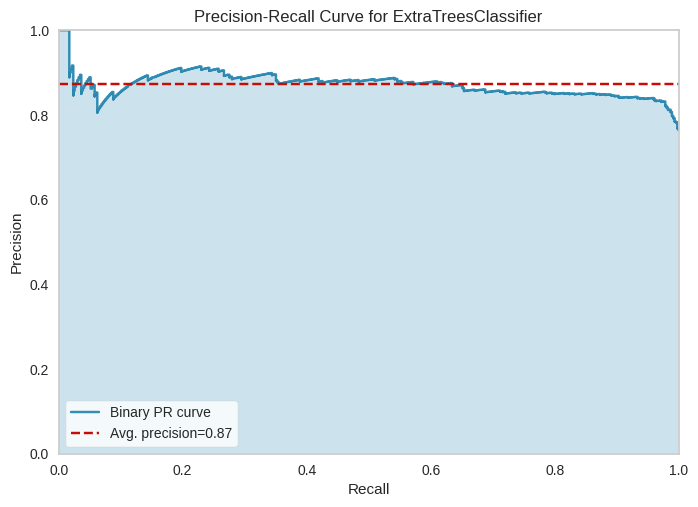

In [53]:
plot_model(tuned_model, plot = 'pr')

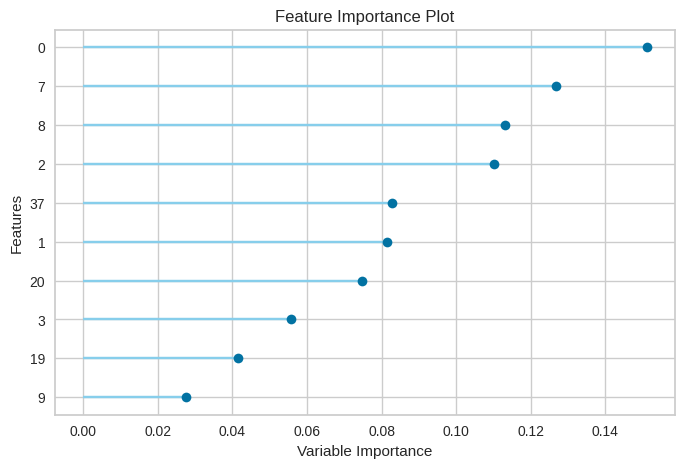

In [54]:
plot = plot_model(tuned_model, plot='feature')

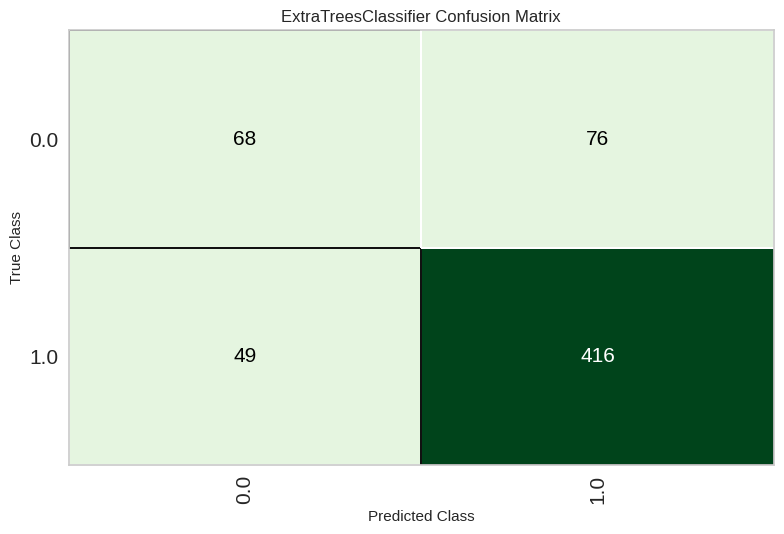

In [55]:
plot_model(tuned_model, plot = 'confusion_matrix')

In [56]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
#final_model = finalize_model(tuned_model)
#print(final_model)